# Preliminary operations
If you run this program on Colab
1.   Install pyomo
2.   Install coin-or cbc
3.   Mount your drive

If you run this program on your pc
1.   Install pyomo once and for all: 
```python
pip install pyomo
```
2.   Install coin-or cbc solver once and for all:<BR>
    2.1 download the sw from https://github.com/coin-or/Cbc/releases  
    2.2 install it in a dyrectory, e.g., C:/Program Files/Cbc

COIN-OR CBC is a multi-threaded open-source Coin-or branch and cut mixed-integer linear programming solver written in C++ under the Eclipse Public License (EPL). CBC is generally a good choice for a general purpose MILP solver for medium to large scale problems.

In [ ]:
working_in_colab = False # Set this variable equal to True if you are working in Colab, False otherwise

if working_in_colab:
    # On Colab only
    # This needs to be done once at the start of each session.
    !pip install -q pyomo              # Quiet installation of pyomo using pip.
    !apt-get install -y -qq coinor-cbc # Installation of COIN-OR CBC.
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)   # Mount your drive


1.   Set input data directory
2.   Set cbc solver path


In [ ]:
if working_in_colab:
    input_directory =  "/content/drive/MyDrive/Corrente/Colab Notebooks/MDMM/BasicModels/Input/" # set the path of the directory of the json data file, e.g., "/content/drive/MyDrive/Corrente/Colab Notebooks/BasicModels/Input/"
    cbc_path = "/usr/bin/cbc"
else:
    input_directory = "./input/"
    cbc_path = "C:/Program Files/Cbc/bin/cbc.exe" # write the path of the cbc.exe file on your pc

# An Assignment problem
A company has 4 machines available for assignment to 4 tasks. Any machine can be assigned to any task, and each task requires processing by one machine.
The time required to set up each machine for the processing of each task is given in the table below.

\begin{matrix}
& Task\,1 & Task\,2 & Task\,3 & Task\,4 \\
Machine\,1  &  13 & 4 & 7 & 6\\
Machine\,2  &  1 & 11 & 5 & 4\\   
Machine\,3  & 6 & 7 & 2 & 8\\
Machine\,4  & 1 & 3 & 5 & 9\\
\end{matrix}

The company wants to minimize the total setup time needed for the processing of all four tasks.

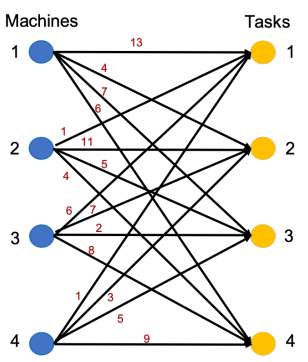


Model formulation
=================

\begin{align*}
\min~&13 x_{11} + 4 x_{12} + 7 x_{13}  + 6 x_{14} +x_{21}    + 11 x_{22} +5 x_{23} + 4 x_{24} +\\
&+ 6 x_{31}  + 7 x_{32} + 2 x_{33} + 8 x_{34}  +x_{41}    + 3 x_{42} + 5 x_{43} + 9 x_{44} \\ \ \\
&x_{11} + x_{12} + x_{13} + x_{14} = 1\\
&x_{21} + x_{22} + x_{23} + x_{24} = 1\\
&x_{31} + x_{32} + x_{33} + x_{34} = 1	\quad\text{each machine serves a single task}\\
&x_{41} + x_{42} + x_{43} + x_{44} = 1\\ \ \\
&x_{11} + x_{21} + x_{31} + x_{41} = 1\\
&x_{12} + x_{22} + x_{32} + x_{42} = 1\\
&x_{13} + x_{23} + x_{33} + x_{43} = 1\quad\text{each task is served by a single machine}\\
&x_{14} + x_{24} + x_{34} + x_{44} = 1\\ \ \\
& x_{ij} \in \{0,1\}, \text{ for  $i = 1,\ldots,4$, $j=1,\ldots,4$}\\
\end{align*}


In [ ]:
import pyomo.environ as pyo
import json

def read_dictionary_from_json(buffer):
    with open(buffer, 'r') as fp:
        dictionary = json.load(fp)
    return dictionary, None

# create a model
model = pyo.ConcreteModel(name="Assignment")

# Read the model parameters
dict_data, msg =read_dictionary_from_json(f"{input_directory}assignment.json")
if msg: raise Exception(msg)

print("Assignment model")

# Declare decision variables
model.x = pyo.Var(dict_data['Machines'].keys(), dict_data['Tasks'], domain=pyo.Binary)

# declare objective
# minimize the setup times
model.Objective = pyo.Objective(expr = sum(dict_data['Machines'][m][t]*model.x[m,t] for m in dict_data['Machines'] for t in dict_data['Machines'][m]), sense=pyo.minimize)

# declare constraints
# at most one task per machine
def machine_constraint_rule(model, m):
    return sum(model.x[m,t] for t in dict_data['Machines'][m]) <= 1
model.MachineConstraints = pyo.Constraint(dict_data['Machines'].keys(), rule = machine_constraint_rule, name = 'Machine constraint')
# one machine per task
def machine_task_rule(model, t):
    return sum (model.x[m,t] for m in dict_data['Machines']) == 1
model.TaskConstraints = pyo.Constraint(dict_data['Tasks'], rule = machine_task_rule, name = 'Tasks constraint')

model.pprint()

## Model solution ##

In [ ]:
# solve the model
opt = pyo.SolverFactory('cbc', executable=cbc_path)
results = opt.solve(model, tee=True)

# display solution
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
      print('\nOptimal solution found')
elif (results.solver.termination_condition == pyo.TerminationCondition.feasible):
      print('\nFeasible but not proven optimal solution found')
elif (results.solver.termination_condition == pyo.TerminationCondition.infeasible):
      raise Exception("The model is infeasible")
else:
    # Something else is wrong
    print('\nSolver Status: ',  results.solver.status)
    raise Exception(results.solver.status)

# display optimal values of decision variables
print('\nObject function value = ', model.Objective())

print('\nDecision Variables')
for m in dict_data['Machines']:
    for t in dict_data['Machines'][m]:
        if int(model.x[m,t]()) == 1:
            print(f"x[{m,t}]: {int(model.x[m,t]()):d}, set-up time: {dict_data['Machines'][m][t]:d}")

print('\nConstraints')
model.MachineConstraints.display()
model.TaskConstraints.display()